In [5]:
!pip install -qq -U diffusers transformers accelerate ftfy

In [2]:
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np

def show_images(x):
    """Given a batch of images x, make a grid and convert to PIL"""
    x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im

In [3]:
import torch
device = torch.device("cuda")
device

device(type='cuda')

In [4]:
from datasets import load_dataset, ReadInstruction, Dataset

dataset2=load_dataset("huggan/AFHQv2", split="train")

Downloading:   0%|          | 0.00/827 [00:00<?, ?B/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/parquet/huggan--AFHQv2-ba10849f3e804334/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901. Subsequent calls will reuse this data.


In [5]:
dataset2

Dataset({
    features: ['image', 'label'],
    num_rows: 15803
})

In [9]:
import torchvision
from torchvision import transforms


image_size= 256
batch_size = 4

preprocess = transforms.Compose(
    [
        transforms.Resize((image_size,image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5],[0.5]),
    ]
)

def transforms(examples):
  images = [preprocess(image.convert("RGB")) for image in examples["image"]]
  return {"images": images}

dataset2.set_transform(transforms)

train_dataloader = torch.utils.data.DataLoader(dataset2, batch_size=batch_size, shuffle=True)

In [10]:
batch=next(iter(train_dataloader))
batch["images"].shape

torch.Size([4, 3, 256, 256])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  


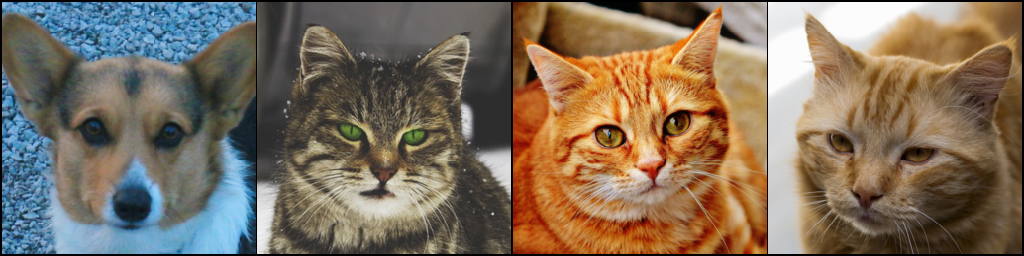

In [11]:
xb=batch["images"].to(device)[:4]
show_images(xb).resize((4*256,256), resample=Image.NEAREST)

In [12]:
from diffusers import DDPMPipeline
import torch

image_pipe = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256")
image_pipe.to(device);

Downloading:   0%|          | 0.00/180 [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/790 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256 [00:00<?, ?B/s]

In [13]:
from diffusers import DDIMScheduler
sampling_scheduler = DDIMScheduler.from_config("google/ddpm-celebahq-256")
sampling_scheduler.set_timesteps(num_inference_steps=50)

In [14]:
import wandb
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [16]:
wandb.init(project="Diffusion_test", config={"learning_rate": 1e-5,
    "architecture": "ddpm-celebahq-256",
    "dataset": "animals",
    "image_size" : 256,
    "batch" : 4,
    "grad_accumulation_steps": 4,                                       
    "epochs": 1,})

In [18]:
import torch.nn.functional as F
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np

lr = 1e-5
num_epochs= 1
grad_accumulation_steps = 4
log_samples_every = 400
save_model_every = 2500

optimizer = torch.optim.AdamW(image_pipe.unet.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

losses =[]

for epoch in range(num_epochs):
  for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
    #add noise
    clean_images=batch["images"].to(device)
    noise = torch.randn_like(clean_images).to(clean_images.device)
    bs = clean_images.shape[0]
    timesteps = torch.randint(0,image_pipe.scheduler.num_train_timesteps, (bs,), device=clean_images.device).long()
    noisy_images = image_pipe.scheduler.add_noise(clean_images, noise, timesteps)
    
    #predict noise
    noise_predict = image_pipe.unet(noisy_images, timesteps, return_dict=False)[0]

    #loss
    loss = F.mse_loss(noise_predict, noise)
    wandb.log({'loss':loss.item()})
    loss.backward(loss)
    losses.append(loss.item())

    #update model params
    if (step + 1) % grad_accumulation_steps == 0:
        optimizer.step()
        optimizer.zero_grad()
    
    #occasionally_log_samples
    if (step+1)%log_samples_every == 0:
      x = torch.randn(8, 3, 256, 256).to(device) # Batch of 8
      for i, t in tqdm(enumerate(sampling_scheduler.timesteps)):
        model_input = sampling_scheduler.scale_model_input(x, t)
        with torch.no_grad():
          noise_pred = image_pipe.unet(model_input, t)["sample"]
        x = sampling_scheduler.step(noise_pred, t, x).prev_sample
        grid = torchvision.utils.make_grid(x, nrow=4)
        im = grid.permute(1, 2, 0).cpu().clip(-1, 1)*0.5 + 0.5
        im = Image.fromarray(np.array(im*255).astype(np.uint8))
        wandb.log({'Sample generations': wandb.Image(im)})
      
  scheduler.step()
  print(
        f"Epoch {epoch} average loss: {sum(losses[-len(train_dataloader):])/len(train_dataloader)}"
    )

  0%|          | 0/3951 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 0 average loss: 0.015182754440348783


In [19]:
image_pipe.save_pretrained("human_to_animals")

In [21]:
!nvidia-smi

Tue Jan  3 10:33:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    33W / 250W |  12905MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [20]:
wandb.finish()

loss,▁▁▂▁▁▁▂▁▄▂▁▁█▄▂▂▃▂▃▁▁▁▂▁▁▁▁▁▁▃▂▁▂▂▂▆▁▁▁▃
loss,0.00683


  0%|          | 0/50 [00:00<?, ?it/s]

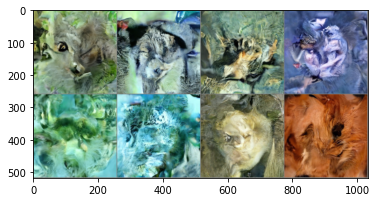

In [22]:
x = torch.randn(8, 3, 256, 256).to(device)  # Batch of 8
for i, t in tqdm(enumerate(sampling_scheduler.timesteps), total=len(sampling_scheduler.timesteps)):
    model_input = sampling_scheduler.scale_model_input(x, t)
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]
    x = sampling_scheduler.step(noise_pred, t, x).prev_sample
grid = torchvision.utils.make_grid(x, nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5);

In [23]:
from huggingface_hub import notebook_login

notebook_login()

In [32]:

# @title Upload a locally saved pipeline to the hub

# Code to upload a pipeline saved locally to the hub
from huggingface_hub import HfApi, ModelCard, create_repo, get_full_repo_name

# Set up repo and upload files
model_name = "ddpm-celebahq-finetuned-animals-1epoch"  # @param What you want it called on the hub
local_folder_name = "human_to_animals"  # @param Created by the script or one you created via image_pipe.save_pretrained('save_name')
description = "finetuned_model_on_animals"  # @param
hub_model_id = get_full_repo_name(model_name)
create_repo(hub_model_id)
api = HfApi()
api.upload_folder(
    folder_path=f"{local_folder_name}/scheduler", path_in_repo="", repo_id=hub_model_id
)
api.upload_folder(
    folder_path=f"{local_folder_name}/unet", path_in_repo="", repo_id=hub_model_id
)
api.upload_file(
    path_or_fileobj=f"{local_folder_name}/model_index.json",
    path_in_repo="model_index.json",
    repo_id=hub_model_id,
)

# Add a model card (optional but nice!)
content = f"""
---
license: mit
tags:
- pytorch
- diffusers
- unconditional-image-generation
- diffusion-models-class
---

# Example Fine-Tuned Model for Unit 2 of the [Diffusion Models Class 🧨](https://github.com/huggingface/diffusion-models-class)

{description}

## Usage

```python
from diffusers import DDPMPipeline

pipeline = DDPMPipeline.from_pretrained('{hub_model_id}')
image = pipeline().images[0]
image
```
"""

card = ModelCard(content)
card.push_to_hub(hub_model_id)

'https://huggingface.co/Thabet/ddpm-celebahq-finetuned-animals-1epoch/blob/main/README.md'

In [29]:
!ls {"human_to_animals"}

model_index.json  scheduler  unet


# Clip & color guidance

In [8]:
# Load the pretrained pipeline
from diffusers import DDPMPipeline, DDIMScheduler
import torch

pipeline_name = "Thabet/ddpm-celebahq-finetuned-animals-1epoch"
image_pipe = DDPMPipeline.from_pretrained(pipeline_name).to(device)

# Sample some images with a DDIM Scheduler over 40 steps
scheduler = DDIMScheduler.from_pretrained(pipeline_name)
scheduler.set_timesteps(num_inference_steps=40)

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

In [9]:
!pip install open-clip-torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 3.1 MB/s eta 0:00:0000:0100:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 24.6 MB/s eta 0:00:0000:01
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.4
    Uninstalling protobuf-3.19.4:
      Successfully uninstalled protobuf-3.19.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
tfx-bsl 1.9.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,!=2.8.*,<3,>=1.15.5, but you have tensorflow 2.6.4 which is incompatible.
tensorflow 2.6.4 requires h5py~=3.1.0, but you have h5py 3.7.0 which is incompatible.
tensorflow 2.6.4 requires numpy~=1.19.2, but you h

In [10]:
import open_clip

clip_model, _, preprocess = open_clip.create_model_and_transforms("ViT-B-32", pretrained="openai")
clip_model.to(device);

100%|███████████████████████████████████████| 354M/354M [00:07<00:00, 49.5MiB/s]


In [19]:
def color_loss(images, target_color=(0.1, 0.9, 0.5)):
    """Given a target color (R, G, B) return a loss for how far away on average
    the images' pixels are from that color. Defaults to a light teal: (0.1, 0.9, 0.5)"""
    target = (torch.tensor(target_color).to(images.device) * 2 - 1)  # Map target color to (-1, 1)
    target = target[None, :, None, None]  # Get shape right to work with the images (b, c, h, w)
    error = torch.abs(images - target).mean()  # Mean absolute difference between the image pixels and the target color
    return error

In [20]:
import torchvision
from torchvision import transforms

tfms = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomResizedCrop(224),  # Random CROP each time
        torchvision.transforms.RandomAffine(
            5
        ),  # One possible random augmentation: skews the image
        torchvision.transforms.RandomHorizontalFlip(),  # You can add additional augmentations if you like
        torchvision.transforms.Normalize(
            mean=(0.48145466, 0.4578275, 0.40821073),
            std=(0.26862954, 0.26130258, 0.27577711),
        ),
    ]
)

def clip_loss(image, text_features):
    image_features = clip_model.encode_image(tfms(image))  # Note: applies the above transforms
    input_normed = torch.nn.functional.normalize(image_features.unsqueeze(1), dim=2)
    embed_normed = torch.nn.functional.normalize(text_features.unsqueeze(0), dim=2)
    dists = (input_normed.sub(embed_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2))  # Squared Great Circle Distance
    return dists.mean()

In [21]:
prompt = "A photo of a grey cat"

text = open_clip.tokenize([prompt]).to(device)
with torch.no_grad(), torch.cuda.amp.autocast():
    text_features = clip_model.encode_text(text)

  0%|          | 0/40 [00:00<?, ?it/s]

Step: 0 , Guidance loss: 23.027843475341797
Step: 10 , Guidance loss: 20.39275550842285
Step: 20 , Guidance loss: 20.124496459960938
Step: 30 , Guidance loss: 20.3743896484375


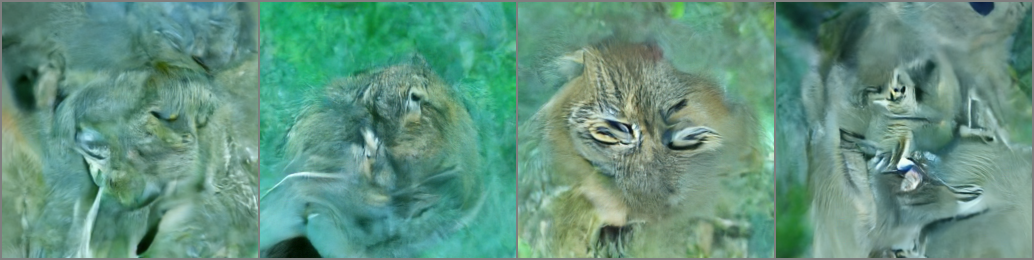

In [23]:
from tqdm.auto import tqdm

guidance_clip_scale = 16  # @param
guidance_color_scale = 15
n_cuts = 4  # @param
x = torch.randn(4, 3, 256, 256).to(device)  # RAM usage is high, you may want only 1 image at a time

for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):

    model_input = scheduler.scale_model_input(x, t)
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]

    cond_grad = 0
    for cut in range(n_cuts):
        # Set requires grad on x
        x = x.detach().requires_grad_()
        # Get the predicted x0:
        x0 = scheduler.step(noise_pred, t, x).pred_original_sample
        # Calculate loss
        loss = clip_loss(x0, text_features) * guidance_clip_scale + color_loss(x0) * guidance_color_scale
        # Get gradient (scale by n_cuts since we want the average)
        cond_grad -= torch.autograd.grad(loss, x)[0] / n_cuts
    
    if i % 10 == 0:
        print("Step:", i, ", Guidance loss:", loss.item())

    # Modify x based on this gradient
    #alpha_bar = scheduler.alphas_cumprod[i]
    x = x.detach() + cond_grad  # Note the additional scaling factor here!

    # Now step with scheduler
    x = scheduler.step(noise_pred, t, x).prev_sample


grid = torchvision.utils.make_grid(x.detach(), nrow=4)
im = grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5
Image.fromarray(np.array(im * 255).astype(np.uint8))